In [67]:
# from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

import pandas as pd
import numpy as np
import scipy.optimize
import re
import os
import importlib
from collections import OrderedDict
import itertools
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter

import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot
from trmc.plot import exp_formatter

# mpl.rcParams['figure.figsize'] = [8, 8]
mpl.rc('font',**{'size' : 18})

In [68]:
def fluencered(da, fluencesel):
    """selects a fluence by index, which will be a different numerical value for each sample"""
    da_s = da.dropna('fluence','all').isel(fluence = fluencesel)
    if 'time' in da_s.indexes:
        da_s = da_s.dropna('time','all')
    return da_s
    
def fluencenorm(da):
    fluence = da.coords['fluence'].values.item()
    da.name = '$\Delta G_r/I_0$ \n $(S/(1/cm^3)) $'
    return da/fluence

        

In [69]:
%store -r sigr
%store -r sigi

fgcol = None if (len(sigr.indexes['sample']) == 1)  else 'sample'
fgrow = None if (len(sigr.indexes['direction']) == 1)  else 'direction'


## Downselect data 

In [70]:
# sigr_s = sigr.groupby('sample').apply(fluencered, fluencesel = slice(2,-1))
# sigi_s = sigi.groupby('sample').apply(fluencered, fluencesel = slice(2,-1))
sigr_s = sigr
sigi_s = sigi

In [71]:
def get_figaxes_facetgrid(g):
    if type(g) == xr.plot.facetgrid.FacetGrid:
        return g.fig, g.axes.flatten()
    elif type(g) == list:
        if type(g[0]) == mpl.lines.Line2D:
            return g[0].figure, [g[0].axes]
#     axs = g.axes.flatten() if type(g.axes) == np.ndarray else [g.axes]

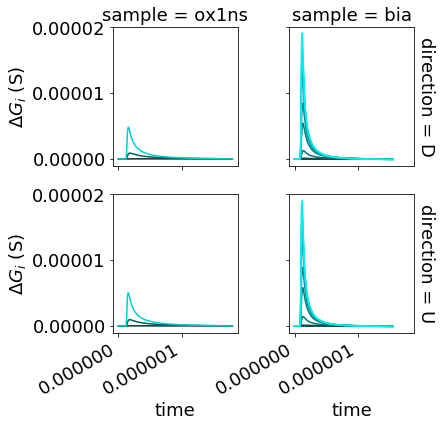

In [72]:
g = sigi_s.plot(row = fgrow, col = fgcol,x = 'time', hue = 'fluence')
# plt.yscale('log')

fig, axes = get_figaxes_facetgrid(g)

for ax in axes:
    plot.removena_axes(ax)
    lns = ax.lines   
    for i, ln in enumerate(lns):
        color = (0,i/len(lns),i/len(lns))
        ln.set_color(color)
#         print(get_label_for_line(ln))

fig.legends[0].remove() if len(fig.legends) > 0 else ax.get_legend().remove()
fig.autofmt_xdate()

## Calculate real/imaginary ratio

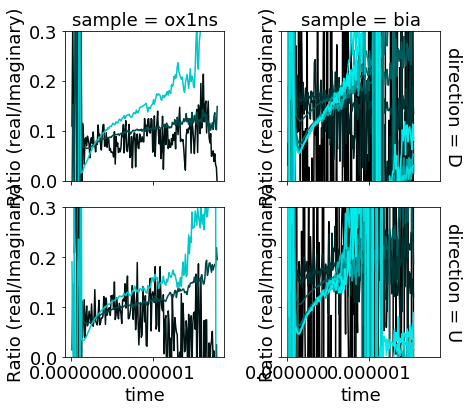

In [93]:
ratio = (sigr_s/sigi_s)
g = ratio.dropna('fluence','all').plot(x='time',hue = 'fluence',row = fgrow, col = fgcol)

fig, axes = get_figaxes_facetgrid(g)
fig.legends[0].remove() if len(fig.legends) > 0 else ax.get_legend().remove()

for ax in axes:
    plot.removena_axes(ax)
    ax.set_ylim([0,0.3])
#     ax.set_xlim([100e-9,1500e-9])
    ax.set_ylabel('Ratio (real/Imaginary)')
    lns = ax.lines
    for i, ln in enumerate(lns):
        color = (0,i/len(lns),i/len(lns))
        ln.set_color(color)
#         mean = ln.get_ydata().mean()
#         if mean == mean:
#             string = ax.title.get_text() + '\n   mean: ' + '{0:.3f}'.format(mean)
#             ax.set_title(string)

## Linear fitting of $log(\sigma)$

In [95]:
sigi_ln = np.log(sigi_s)
sigr_ln = np.log(sigr_s)

keys = ['fluence']
if len(sigi_ln.indexes['sample']) > 0:
    keys.append('sample') 
if len(sigi_ln.indexes['direction']) > 0:
    keys.append('direction') 

seldicts = load.gen_seldicts(sigi_ln,keys, check_empty=True)

timeslice = slice(400e-9,600e-9)

### Real

In [96]:
da = sigr_ln
title = 'Real'
da_fits = da.where(False).copy()
da_p = da.isel(time = 0).drop('time').where(False).copy()

for seldict in seldicts:
    d = da.sel(seldict).dropna('time').to_series()
    d = d.replace(-np.inf, np.nan)
    d = d.replace(np.inf, np.nan)
    d = d.dropna()
    dsel = d.loc[timeslice]
    
    p = np.polyfit(dsel.index,dsel.values,1)
    
    da_p.loc[seldict] = p[0]
    f = np.poly1d(p)
    fit = pd.Series(f(dsel.index), index = dsel.index)
    tempseldict = seldict.copy()
    tempseldict['time'] = dsel.index
    da_fits.loc[tempseldict]  = fit

Text(0.5, 0.98, 'Real')

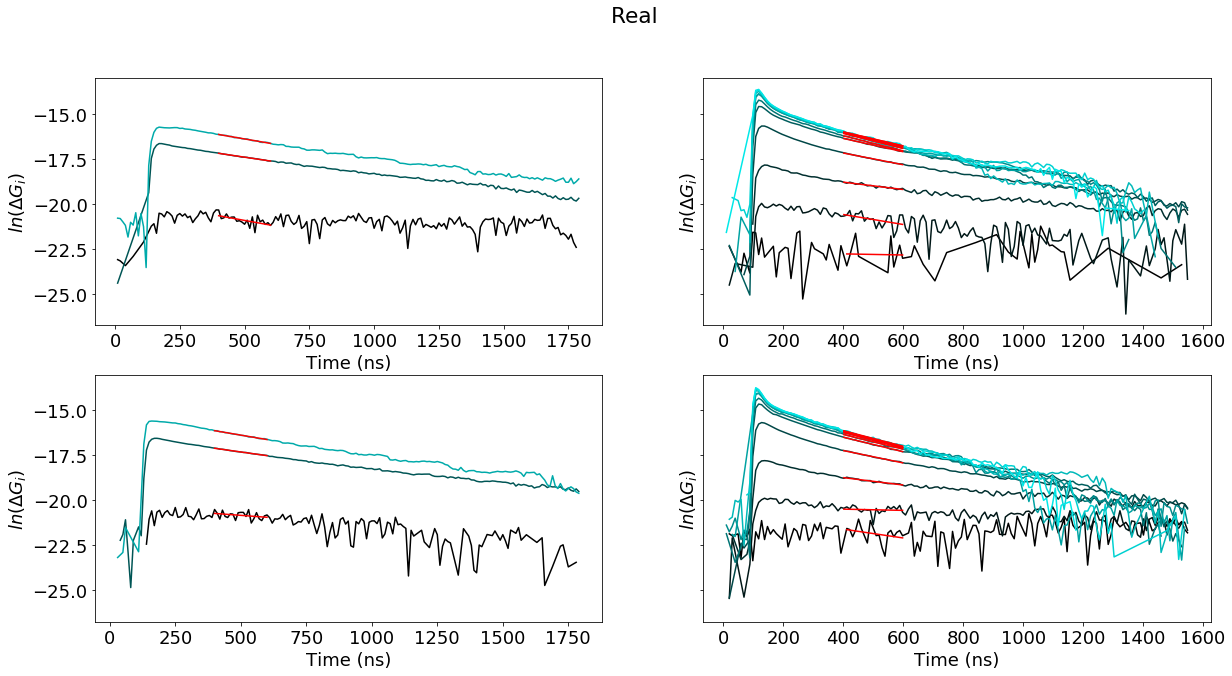

In [97]:
fig,axes = plt.subplots(2,len(da.indexes['sample']), sharey = True, figsize = (20,10), squeeze=False)

colsel = {}
for i, item in enumerate(da.indexes['sample']):
    colsel[item] = i
    
rowsel = {}
for i, item in enumerate(da.indexes['direction']):
    rowsel[item] = i

for seldict in seldicts:
    col = colsel[seldict['sample']]
    row = rowsel[seldict['direction']]
    data = da.sel(seldict).to_series().dropna()
    axes[row][col].plot(data)
    
for ax in axes.flatten():
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    ax.set_ylabel('$ln(\\Delta G_i )$')
    ax.set_xlabel('Time (ns)')
    lns = ax.lines
    for i, ln in enumerate(lns):
        color = (0,i/len(lns),i/len(lns))
        ln.set_color(color)
#     ax.set_ylim([da.min(),-13])
        
for seldict in seldicts:
    col = colsel[seldict['sample']]
    row = rowsel[seldict['direction']]
    fit = da_fits.sel(seldict).to_series().dropna()
    axes[row][col].plot(fit, color = 'r')
    
fig.suptitle(title)

Text(0.5, 0.98, 'Real')

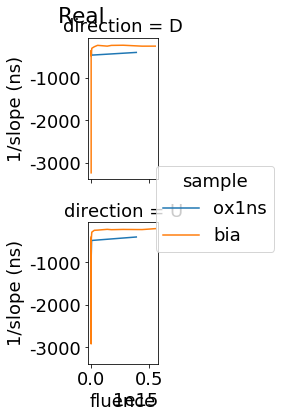

In [98]:
da_p_tau = 1/da_p
da_p_tau.name = '1/slope (ns)'
g = da_p_tau.plot(x = 'fluence', row = fgrow, hue = 'sample')

for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    plot.removena_axes(ax)
#     ax.set_ylim([-1e7,0])

g.fig.suptitle(title)

### Imaginary

Text(0.5, 0.98, 'Real')

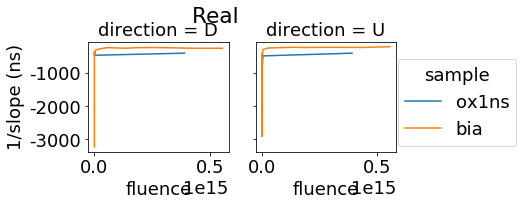

In [99]:
da_p_tau = 1/da_p
da_p_tau.name = '1/slope (ns)'
g = da_p_tau.plot(x = 'fluence', col = 'direction', hue = 'sample')

for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    plot.removena_axes(ax)
#     ax.set_ylim([-1e7,0])

g.fig.suptitle(title)

## Look at time required for fractional decay

### Real

In [100]:
da = sigi_ln
title = 'Imaginary'
da_fits = da.where(False).copy()
da_p = da.isel(time = 0).drop('time').where(False).copy()

for seldict in seldicts:
    d = da.sel(seldict).dropna('time').to_series()
    d = d.replace(-np.inf, np.nan)
    d = d.replace(np.inf, np.nan)
    d = d.dropna()
    dsel = d.loc[timeslice]
    
    p = np.polyfit(dsel.index,dsel.values,1)
    
    da_p.loc[seldict] = p[0]
    f = np.poly1d(p)
    fit = pd.Series(f(dsel.index), index = dsel.index)
    tempseldict = seldict.copy()
    tempseldict['time'] = dsel.index
    da_fits.loc[tempseldict]  = fit

Text(0.5, 0.98, 'Imaginary')

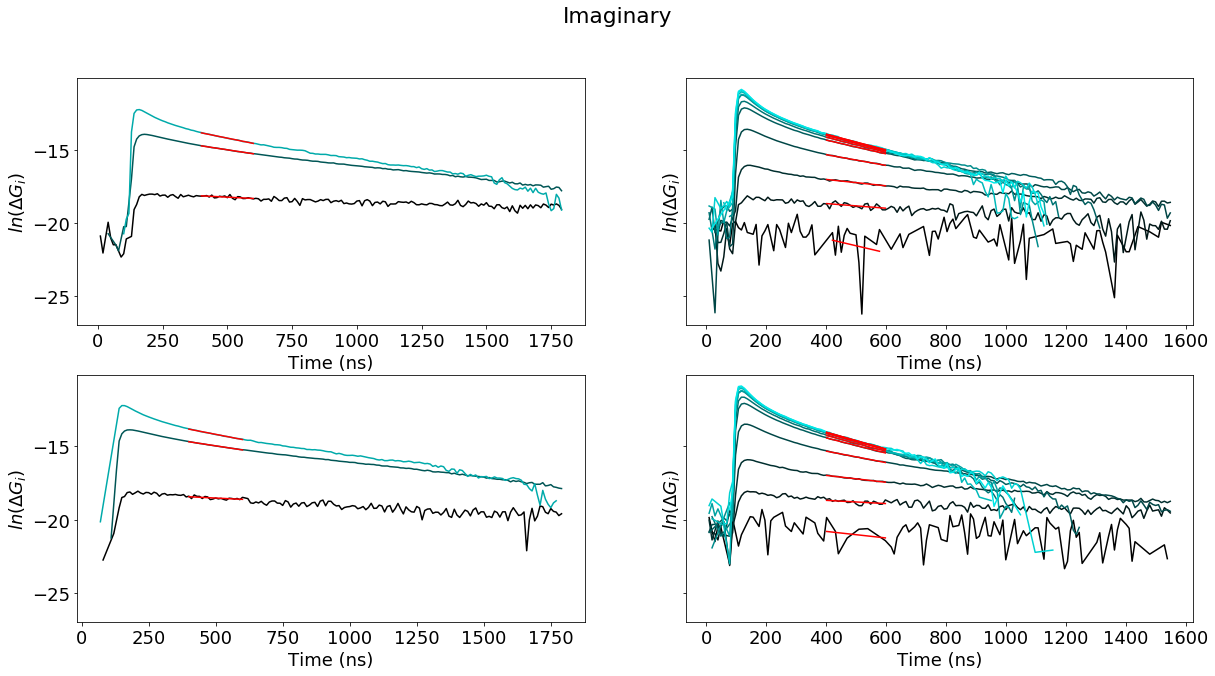

In [101]:
fig,axes = plt.subplots(2,len(da.indexes['sample']), sharey = True, figsize = (20,10), squeeze=False)

colsel = {}
for i, item in enumerate(da.indexes['sample']):
    colsel[item] = i
    
rowsel = {}
for i, item in enumerate(da.indexes['direction']):
    rowsel[item] = i

for seldict in seldicts:
    col = colsel[seldict['sample']]
    row = rowsel[seldict['direction']]
    data = da.sel(seldict).to_series().dropna()
    axes[row][col].plot(data)
    
for ax in axes.flatten():
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    ax.set_ylabel('$ln(\\Delta G_i )$')
    ax.set_xlabel('Time (ns)')
    lns = ax.lines
    for i, ln in enumerate(lns):
        color = (0,i/len(lns),i/len(lns))
        ln.set_color(color)
#     ax.set_ylim([da.min(),-13])
        
for seldict in seldicts:
    col = colsel[seldict['sample']]
    row = rowsel[seldict['direction']]
    fit = da_fits.sel(seldict).to_series().dropna()
    axes[row][col].plot(fit, color = 'r')
    
fig.suptitle(title)

In [102]:
da = sigr_s
#Get Rid of time dimension
da_dt = da.isel(time = 0).drop('time').copy()
# Add new dimension of fraction, and assign coordinates. forward fill so that accurate selection dictionaries can be made.
fracs = np.linspace(2,100)
da_dt = da_dt.expand_dims('frac').assign_coords(frac = [fracs[0]]).reindex(frac = fracs,method = 'ffill')
seldicts_frac = load.gen_seldicts(da_dt,list(da_dt.indexes.keys()))
#After selection dicts are made, fill all valuues to nan
da_dt = da_dt.where(False)
da_dt.name = 'Reduction Time'

for seldict in seldicts_frac:
    seldict_red = {key :seldict[key] for key in seldict if key is not 'frac'}
    d = da.sel(seldict_red).dropna('time').to_series()
    dmax = d.max()
    tmax = d.idxmax()
    dred = d.loc[tmax:]
    
    dfrac = dmax/seldict['frac']
    tfrac = abs(dred-dfrac).idxmin()
    dt = tfrac-tmax
    da_dt.loc[seldict] = dt

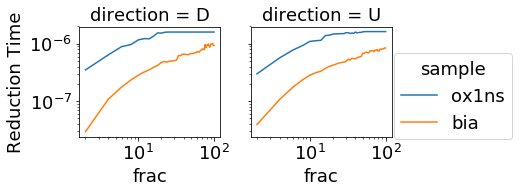

In [103]:
da_dt_s = da_dt.groupby('sample').apply(fluencered,fluencesel = -1)

g = da_dt_s.plot(col = 'direction', hue = 'sample')

for ax in g.axes.flatten():
    plot.removena_axes(ax)

plt.yscale('log')
plt.xscale('log')

### Imaginary

In [104]:
da = sigi_s
#Get Rid of time dimension
da_dt = da.isel(time = 0).drop('time').copy()
# Add new dimension of fraction, and assign coordinates. forward fill so that accurate selection dictionaries can be made.
fracs = np.linspace(2,100)
da_dt = da_dt.expand_dims('frac').assign_coords(frac = [fracs[0]]).reindex(frac = fracs,method = 'ffill')
seldicts_frac = load.gen_seldicts(da_dt,list(da_dt.indexes.keys()))
#After selection dicts are made, fill all valuues to nan
da_dt = da_dt.where(False)
da_dt.name = 'Reduction Time'

for seldict in seldicts_frac:
    seldict_red = {key :seldict[key] for key in seldict if key is not 'frac'}
    d = da.sel(seldict_red).dropna('time').to_series()
    dmax = d.max()
    tmax = d.idxmax()
    dred = d.loc[tmax:]
    
    dfrac = dmax/seldict['frac']
    tfrac = abs(dred-dfrac).idxmin()
    dt = tfrac-tmax
    da_dt.loc[seldict] = dt

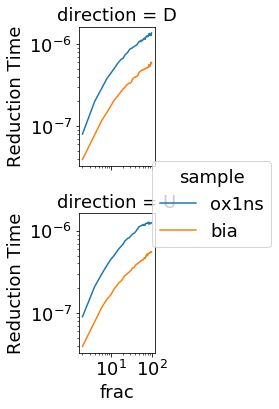

In [105]:
da_dt_s = da_dt.groupby('sample').apply(fluencered,fluencesel = -1)

g = da_dt_s.plot(row = 'direction', hue = 'sample')

for ax in g.axes.flatten():
    plot.removena_axes(ax)

plt.yscale('log')
plt.xscale('log')

# Calculating (complex) figure of merit 

The imaginary component of the fom does not have an apparent physical meaning, but this calculation is useful regardless because it is effectively normalizing by the fluence

In [106]:
beta = 2.25
M = 0.25
FA = 1
e = 1.6e-19

def fom(x):
    fluence = x.coords['fluence'].values
    return x/(beta*e*fluence*FA*M)

fom_r = sigr_s.groupby('fluence').apply(fom)
fom_i = sigi_s.groupby('fluence').apply(fom)

fom_r.name = '$\phi\Sigma\mu_R \ (cm^2/Vs)$'
fom_i.name = '$\phi\Sigma\mu_I \ (cm^2/Vs)$'

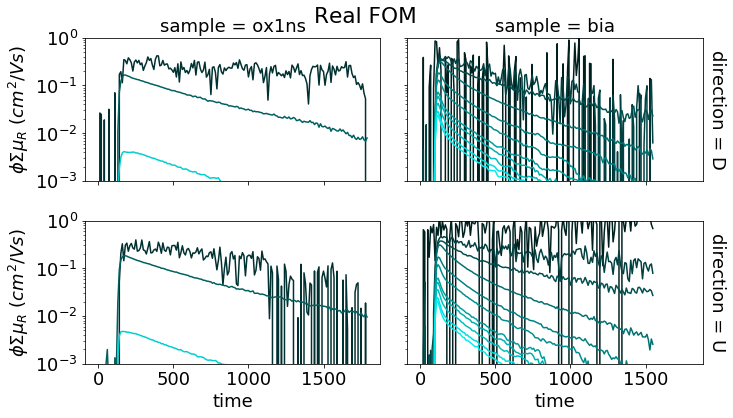

In [107]:
g = fom_r.plot(x = 'time',hue = 'fluence',row = fgrow, col = fgcol)

fig, axes = get_figaxes_facetgrid(g)
fig.legends[0].remove() if len(fig.legends) > 0 else ax.get_legend().remove()

for ax in axes:
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    ax.set_ylim([1e-3,1e0])
    lns = ax.lines
    for i, ln in enumerate(lns):
        plot.dropna_ln(ln)
        color = (0,i/len(lns),i/len(lns))
        ln.set_color(color)
        
# fig.legends[0].remove() if len(fig.legends) > 0 else ax.get_legend().remove()
g.fig.suptitle('Real FOM')
g.fig.tight_layout()


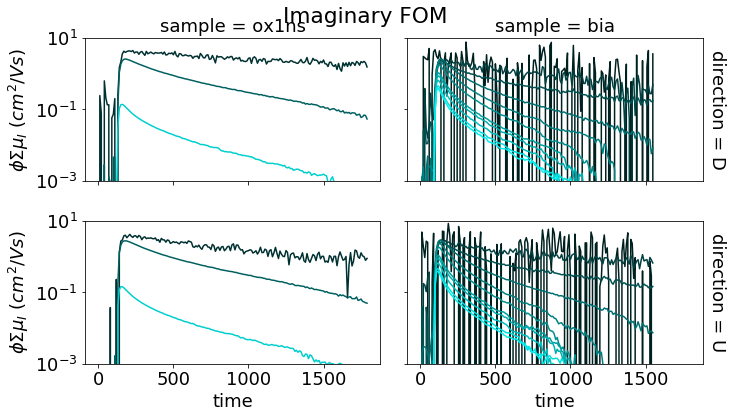

In [108]:
g = fom_i.plot(x = 'time',hue = 'fluence',row = fgrow, col = fgcol )

for ax in g.axes.flatten():
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    ax.set_ylim([1e-3,1e1])
    lns = ax.lines
    for i, ln in enumerate(lns):
        plot.dropna_ln(ln)
    
        color = (0,i/len(lns),i/len(lns))
        ln.set_color(color)
        
g.fig.legends[0].remove()
g.fig.suptitle('Imaginary FOM')
g.fig.tight_layout()

### Select fluence and look by sample

In [88]:
fluencesel = -1
print('Selected Fluence: ' + str(fluencesel))

Selected Fluence: -1


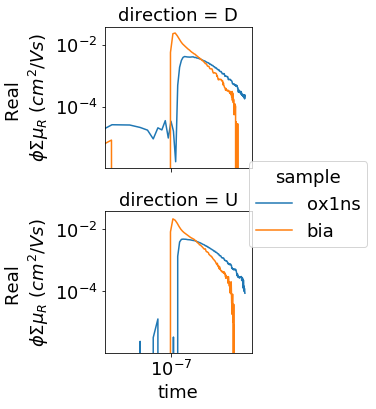

In [89]:
da = fom_r.groupby('sample').apply(fluencered,fluencesel = fluencesel)

g = da.plot(hue = 'sample', row = 'direction')

for ax in g.axes.flatten():
    plot.removena_axes(ax)
    ax.set_ylabel('Real \n$\phi\Sigma\mu_{R} \ (cm^2/Vs)$')
    ax.set_yscale('log')
    ax.set_xscale('log')

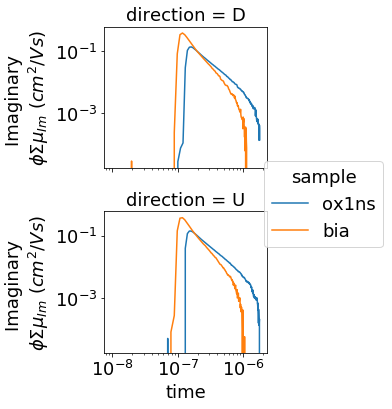

In [90]:
da = fom_i.groupby('sample').apply(fluencered,fluencesel = fluencesel)

g = da.plot(hue = 'sample', row = 'direction')

for ax in g.axes.flatten():
    plot.removena_axes(ax)
    ax.set_ylabel('Imaginary \n$\phi\Sigma\mu_{Im} \ (cm^2/Vs)$')
    ax.set_yscale('log')
    ax.set_xscale('log')

### Maximum FOM

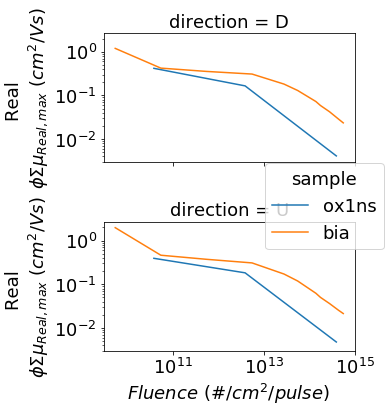

In [91]:
g = fom_r.max('time').plot(x = 'fluence',hue = 'sample', row = 'direction' )

for ax in g.axes.flatten():
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Real \n$\phi\Sigma\mu_{Real, max} \ (cm^2/Vs)$')
    
    plot.removena_axes(ax)
        
g.axes[1][0].set_xlabel('$Fluence \ (\#/cm^2/pulse)$ ')
# g.fig.suptitle('Imaginary')
g.fig.tight_layout()

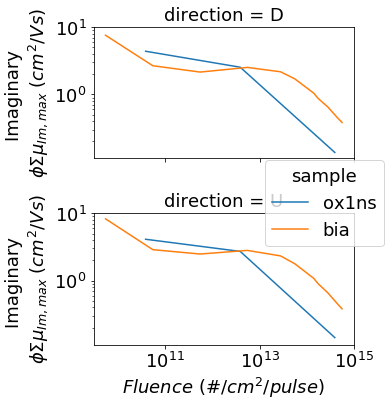

In [92]:
g = fom_i.max('time').plot(x = 'fluence',hue = 'sample', row = 'direction' )

for ax in g.axes.flatten():
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Imaginary \n$\phi\Sigma\mu_{Im, max} \ (cm^2/Vs)$')
    
    plot.removena_axes(ax)
        
g.axes[1][0].set_xlabel('$Fluence \ (\#/cm^2/pulse)$ ')
# g.fig.suptitle('Imaginary')
g.fig.tight_layout()